# DAMLAS - Machine Learning At Scale
## Assignment - HW3
Data Analytics and Machine Learning at Scale
Target, Minneapolis

---
__Name:__  Scott Zuehlke  
__Class:__ DAMLAS Summer 2016    
__Email:__  Scott.Zuehlke@Target.com     
__Week:__   03

# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    3.0.  [Short Answer Questions](#HW3.0)    
    3.1.  [Word Count plus sorting](#HW3.1)   
    3.2.  [MLlib-centric Kmeans](#HW3.2)    
    3.3.  [Homegrown KMeans in Spark](#HW3.3)    
    3.4.  [Making Homegrown KMeans more efficient](#HW3.4)  
    3.5.  [OPTIONAL Weighted KMeans](#HW3.5)  
    3.6.  [OPTIONAL Linear Regression](#HW3.6)  
    3.7.  [OPTIONAL Error surfaces](#HW3.7)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Tueday, 08/02/2016 at 11AM (CT).


* Prepare a single Jupyter note, please include questions, and question numbers in the questions and in the responses.
Submit your homework notebook via the following form:

   + [Submission Link - Google Form](http://goo.gl/forms/er3OFr5eCMWDngB72)


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. __(Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))__
* Ryza, Sandy, Laserson, Uri, Owen, Sean, & Wills, Josh. (2015). Advanced analytics with Spark: Patterns for learning from data at scale. Sebastopol, CA: O’Reilly Publishers.
---
* [Slides for Supervised-ML-Classification-via-GradientDescent](https://www.dropbox.com/s/uzoch1dwft8kaqw/Lecture-15-Supervised-ML-Classification-via-GradientDescent.pdf?dl=0)
* [Slides from High Entropy Friday]( https://www.dropbox.com/s/0dlvsff3660vvbk/Lecture-High-Entropy-Friday.pdf?dl=0)

---

<a name="HW3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="3.0"></a><h2 style="color:darkblue"> HW3.0: Short answer questions </h2>
[Back to Table of Contents](#TOC)


__What is Apache Spark and how is it different to Apache Hadoop? __

Apache Spark is a general data processing and analytics framework.  It can be run on either a single node or a distributed cluster, and is extremely fast as it uses in-memory computations.

By comparison, Hadoop is a distributed computing cluster.  Hadoop uses MapReduce, which is great for analyzing big data, but writes data to disk, and so is much slower than Spark.

<hr>

__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, Scala, R, and Python. __

<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or YARN in a distributed manner. __

<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. __

An RDD (resilient distributed dataset) is a dataset that has distributed storage, is lazily evaluated, can be transformed, and can be either a base RDD or a pair RDD.

<hr>


In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [2]:
# Find and load Spark context

import os
import sys

import pyspark
from pyspark.sql import SQLContext


app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)

print(sc)
print(sqlContext)

import dateutil.parser
import dateutil.relativedelta as dateutil_rd

Example:

In [3]:
%%writefile funexample.txt
Fun examples are fun
But how fun are they?  You will not even see this line in the below cell.

Overwriting funexample.txt


In [4]:
rdd = sc.textFile("funexample.txt")
rdd.first() 

'Fun examples are fun'

<a name="HW3.1"> <h2 style="color:darkgreen">HW3.1 WordCount plus sorting </h2>
[Back to Table of Contents](#TOC)

The following notebooks will be useful to jumpstart this collection of Homework exercises:


* [Example Notebook with Debugging tactics in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/jqjllp8kmf1eolk/WordCountDebugging-Example.ipynb)
* [Word Count Quiz](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/vgmpivsi4rvqz0s/WordCountQuiz.ipynb)
* [Work Count Solution](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dxv3dmp1vluuo8i/WordCountQuiz-Solution.ipynb)

---
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document (with no solutions in it) as a the example document to run an experiment.  Report the following: 
* provide a sorted list of tokens in decreasing order of frequency of occurence limited to [top 20 most frequent only] and [bottom 10 least frequent]. 


__OPTIONAL__ 
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Plseas refer to the [following notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/uu5afr3ufpm9fy8/SecondarySort.ipynb)
 for examples of secondary sorts in Spark. Please provide the following [top 20 most frequent terms only] and [bottom 10 least frequent terms]

__NOTE__ [Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [5]:
import re

hw31top20 = sc.textFile('HW3.txt') \
    .flatMap(lambda line: re.findall(r'[\w]+', line)) \
    .filter(lambda x: len(x) > 1) \
    .map(lambda x: (x, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .takeOrdered(20, key = lambda x: -x[1]) 
print('Most frequent 20 words')
for h in hw31top20:
    print(h)

Most frequent 20 words
('the', 71)
('of', 49)
('and', 40)
('to', 33)
('in', 32)
('HW3', 19)
('Contents', 17)
('this', 17)
('for', 17)
('with', 17)
('Table', 17)
('Back', 16)
('data', 15)
('as', 14)
('KMeans', 14)
('model', 12)
('Spark', 12)
('plot', 12)
('notebook', 12)
('code', 12)


In [6]:
import re

hw31bottom10 = sc.textFile('HW3.txt') \
    .flatMap(lambda line: re.findall(r'[\w]+', line)) \
    .filter(lambda x: len(x) > 1) \
    .map(lambda x: (x, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .takeOrdered(10, key = lambda x: x[1]) 
print('Least frequent 10 words')
for h in hw31bottom10:
    print(h)

Least frequent 10 words
('Java', 1)
('appears', 1)
('driver', 1)
('implentation', 1)
('At', 1)
('PlotModelAndDomainSpaces', 1)
('50', 1)
('versus', 1)
('both', 1)
('numpy', 1)


<a name="HW3.1.1"><h2 style="color:darkgreen">HW3.1.1 </h2>
[Back to Table of Contents](#TOC)

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.


In [7]:
import re

hw311top20 = sc.textFile('HW3.txt') \
    .flatMap(lambda line: re.findall(r'\b[a-z]\w+\b', line)) \
    .filter(lambda x: len(x) > 1) \
    .map(lambda x: (x, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .takeOrdered(20, key = lambda x: -x[1]) 
print('Most frequent 20 words')
for h in hw311top20:
    print(h)

Most frequent 20 words
('the', 71)
('of', 49)
('and', 40)
('to', 33)
('in', 32)
('this', 17)
('for', 17)
('with', 17)
('data', 15)
('as', 14)
('model', 12)
('plot', 12)
('here', 12)
('notebook', 12)
('code', 12)
('is', 10)
('goes', 9)
('clusters', 9)
('space', 9)
('regression', 8)


In [8]:
import re

hw311bottom10 = sc.textFile('HW3.txt') \
    .flatMap(lambda line: re.findall(r'\b[a-z]\w+\b', line)) \
    .filter(lambda x: len(x) > 1) \
    .map(lambda x: (x, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .takeOrdered(10, key = lambda x: x[1]) 
print('Least frequent 10 words')
for h in hw311bottom10:
    print(h)

Least frequent 10 words
('equations', 1)
('appears', 1)
('prediction', 1)
('driver', 1)
('implentation', 1)
('regularization', 1)
('axis', 1)
('make', 1)
('form', 1)
('color', 1)


<a name="HW3.2"> <h2 style="color:darkblue"> HW3.2: MLlib-centric KMeans</h2>
[Back to Table of Contents](#TOC)

Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

In [9]:
!curl -L https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 -o kmeans_data.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     0
curl: (35) Unknown SSL protocol error in connection to www.dropbox.com:443 


In [9]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sum([x**2 for x in (point - center)])

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
WSSSE_mllib = clusters.computeCost(parsedData)
print("WSSSE = " + str(WSSSE))
print("MLlib WSSSE calc = "+str(WSSSE_mllib))
print("Centroids = " + str(clusters.centers))

/usr/local/spark/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


WSSSE = 0.12
MLlib WSSSE calc = 0.11999999999994547
Centroids = [array([ 0.1,  0.1,  0.1]), array([ 9.1,  9.1,  9.1])]


I took out the sqrt() in the error calculation.

This shows there's about a 12% variance between the clusters' data points and the centroid centers.

<a name="HW3.3"><h2 style="color:darkgreen"> HW3.3: Homegrown KMeans in Spark </h2>
[Back to Table of Contents](#TOC)

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb).

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).



In [10]:
%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 100
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [11]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

def error(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    error1 =  np.sum((x-centroids[closest_centroid_idx])**2)
    return (closest_centroid_idx, error1)

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

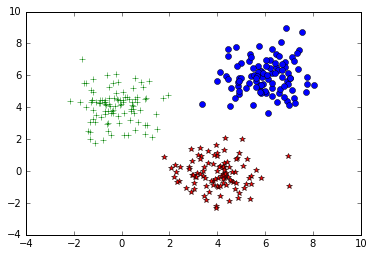

In [12]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

Iteration number: 1
WSSSE is 6988.65306084564 after 1 iterations.
Cluster Centers after 1 iterations:
[ 7.21109302  4.55940186] [ 4.8161421   6.56431234] [ 6.88247985  8.9919541 ]


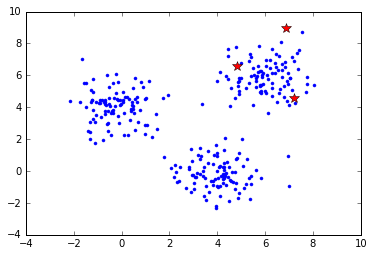

Iteration number: 10
WSSSE is 549.1521486961711 after 10 iterations.
Cluster Centers after 10 iterations:
[ 6.0173594   5.93372792] [ 3.98654244 -0.17906721] [-0.23501274  4.05471244]


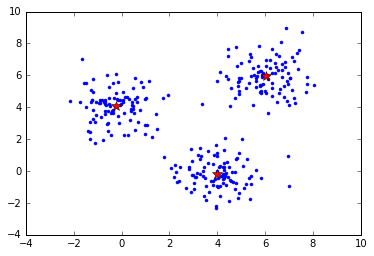

Iteration number: 20
WSSSE is 549.1521486961711 after 20 iterations.
Cluster Centers after 20 iterations:
[ 6.0173594   5.93372792] [ 3.98654244 -0.17906721] [-0.23501274  4.05471244]


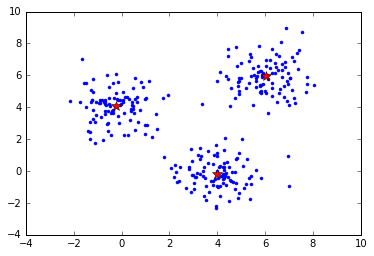

Iteration number: 100
WSSSE is 2259.895811546077 after 100 iterations.
Cluster Centers after 100 iterations:
[ 6.25149582  4.97878176] [ 5.89057795  6.65565457] [ 1.85794905  1.95415568]


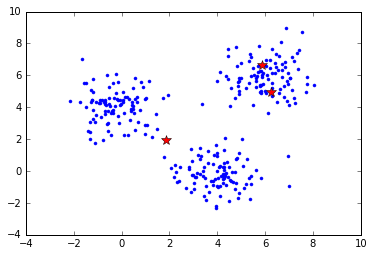

In [21]:
%matplotlib inline

import numpy as np
import pylab as plt
from numpy import array
from pyspark.mllib.clustering import KMeans, KMeansModel

k = 3
iterations = [0, 9, 19, 99]

# create RDD
D = sc.textFile("data.csv").map(lambda line: array([float(x) for x in line.split(',')])).cache()
clusters = None
wsssemllib = []

for iteration in range(150):
    # Build the model (cluster the data)
    clusters = KMeans.train(D, k, maxIterations=iteration, runs=1, initializationMode = "random")
    WSSSEMLlib = clusters.computeCost(D)
    wsssemllib.append(WSSSEMLlib)
    
    if iteration in iterations:
        print("Iteration number: " + str(iteration+1))
        print("WSSSE is " + str(WSSSEMLlib) + " after " + str(iteration+1) + " iterations.")
        print("Cluster Centers after " + str(iteration+1) + " iterations:")
        print(clusters.centers[0], clusters.centers[1], clusters.centers[2])
        plot_iteration(clusters.centers)

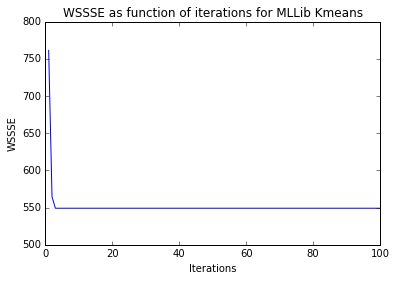

In [16]:
xfull = range(150)
x = [xfull[1], xfull[2], xfull[3], xfull[5], xfull[10], xfull[20], xfull[100]]
y = [wsssemllib[1], wsssemllib[2], wsssemllib[3], wsssemllib[5], wsssemllib[10], wsssemllib[20], wsssemllib[100]]

plt.plot(x, y)
plt.title("WSSSE as function of iterations for MLLib Kmeans")
plt.xlabel("Iterations")
plt.ylabel("WSSSE")
plt.show()

<a name="HW3.4"><h2 style="color:darkblue"> HW3.4: KMeans Experiments  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)   repeat the experiments in HW3.3. Explain any differences between the results in HW3.3 and HW3.4. 

Iteration number: 1
WSSSE after 4816.45028813 iterations.
Cluster Centers after 1 iterations:
[ 3.98654244 -0.17906721] [-0.23501274  4.05471244] [ 6.0173594   5.93372792]


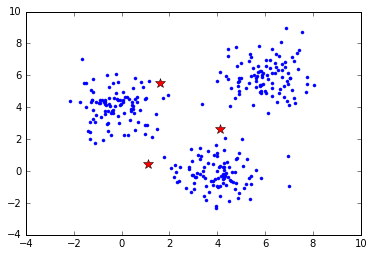

Iteration number: 10
WSSSE after 549.152148696 iterations.
Cluster Centers after 10 iterations:
[ 3.98654244 -0.17906721] [-0.23501274  4.05471244] [ 6.0173594   5.93372792]


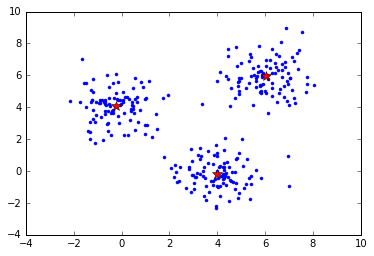

Iteration number: 20
WSSSE after 549.152148696 iterations.
Cluster Centers after 20 iterations:
[ 3.98654244 -0.17906721] [-0.23501274  4.05471244] [ 6.0173594   5.93372792]


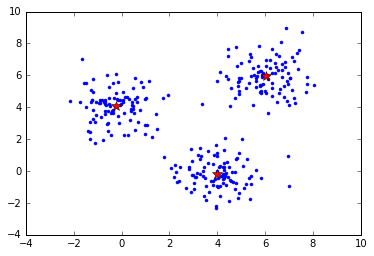

Iteration number: 100
WSSSE after 549.152148696 iterations.
Cluster Centers after 100 iterations:
[ 3.98654244 -0.17906721] [-0.23501274  4.05471244] [ 6.0173594   5.93372792]


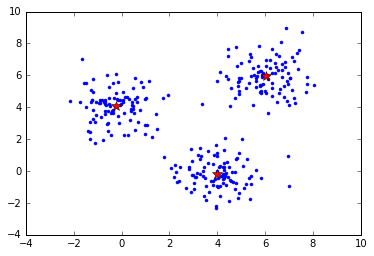

In [19]:
k = 3
iterations = [0, 9, 19, 99]

# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0], [2.0,2.0], [0.0,7.0]])
homegwssse = []
D = sc.textFile("data.csv").cache()

for i in range(150):
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here

    res = sorted(res, key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    
    WSSSEHG = D.map(error).reduceByKey(lambda x, y: x + y).collect()
    hgwssse = 0
    
    for w in WSSSEHG:
        hgwssse += w[1]
        homegwssse.append(hgwssse)
    #if np.sum(np.absolute(centroids_new-centroids))<0.01:
    #    break

    centroids = centroids_new

    if i in iterations:

        print("Iteration number: " + str(i+1))
        print("WSSSE after " + str(hgwssse) + " iterations.")
        print("Cluster Centers after " + str(i+1) + " iterations:")
        print(clusters.centers[0], clusters.centers[1], clusters.centers[2])

        # Plot the points & centroids
        plot_iteration(centroids)

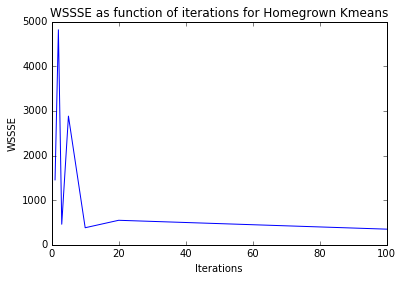

In [18]:
xfull = range(150)
x = [xfull[1], xfull[2], xfull[3], xfull[5], xfull[10], xfull[20], xfull[100]]
y = [homegwssse[1], homegwssse[2], homegwssse[3], homegwssse[5], homegwssse[10], homegwssse[20], homegwssse[100]]

plt.plot(x, y)
plt.title("WSSSE as function of iterations for Homegrown Kmeans")
plt.xlabel("Iterations")
plt.ylabel("WSSSE")
plt.show()

The two methods do eventually converge on the same cluster centers, and therefore with the same WSSSSE, but there is a bit of noise before convergence when running the homegrown.  Therefore, same result but the MLLib version converges faster.

<a name="HW3.4.1"><h2 style="color:darkblue"> HW3.4.1: Making Homegrown KMeans more efficient  </h2>
[Back to Table of Contents](#TOC)

The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. 

### HINT: have a look at  [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

In [97]:
## Code goes here

In [98]:
## Drivers & Runners

In [99]:
## Run Scripts, S3 Sync

<a name="HW3.5"><h2 style="color:darkgreen"> HW3.5: OPTIONAL Weighted KMeans  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb), modify it to do a weighted KMeans and repeat the experiements in HW3.3. Explain  any differences between the results in HW3.3 and HW3.5.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm): 

> weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of two values X1 and X2.

__[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [100]:
## Code goes here

In [101]:
## Drivers & Runners

In [102]:
## Run Scripts, S3 Sync

<a name="HW3.6"><h2 style="color:darkblue"> HW3.6 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)
<a name="HW3.6.1"><h2 style="color:darkblue"> HW3.6.1 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

Using [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb):


* Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

* Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots (e.g., plot MSE as a function of the number of iterations) and words. 


<a name="HW3.6.2"><h2 style="color:darkblue"> HW3.6.2 OPTIONAL Linear Regression</h2>
[Back to Table of Contents](#TOC)

In the notebook provided above, in the cell labeled "Gradient descent (regularization)".

* Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

* Using the data from 3.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.

In [103]:
## Code goes here

In [104]:
## Drivers & Runners

In [105]:
## Run Scripts, S3 Sync

<a name="HW3.7"><h2 style="color:darkgreen"> HW3.7 OPTIONAL Error surfaces </h2>
[Back to Table of Contents](#TOC)

Here is a link to R code with 1 test drivers that plots the linear regression model in  model space and in the domain space:

> https://www.dropbox.com/s/3xc3kwda6d254l5/PlotModelAndDomainSpaces.R?dl=0

Here is a sample output from this script: 
      
> https://www.dropbox.com/s/my3tnhxx7fr5qs0/image%20%281%29.png?dl=0

Please use this as inspiration and code a equivalent error surface and heatmap (with isolines) in Spark and show the trajectory of learning taken during gradient descent(after each n-iterations of Gradient Descent):


Using Spark and  Python (using the above R Script as inspiration), plot the error surface for the linear regression model using a heatmap and contour plot. 
Also plot the current model in the original domain space for every 10th iteration.  Plot them side by side if possible  for each iteration: lefthand side plot is the model space(w0 and w01) and the righthand side plot is domain space (plot the corresponding model and training data in the problem domain space) with a final pair of graphs showing the entire trajectory in the model and domain space. Make sure to label your plots with iteration numbers, function, model space versus original domain space, MSE on the training data etc.

Also plot the MSE as a function of each iteration (possibly every 10th iteration). Dont forget to label both axis and the graph also. __[Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__





In [106]:
## Code goes here

In [107]:
## Drivers & Runners

In [108]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>